In [1]:
import torch
import transformers

In [2]:
import datasets

In [3]:
import torch
from datasets import load_dataset

ds = load_dataset("ylecun/mnist")
ds

Using the latest cached version of the dataset since ylecun/mnist couldn't be found on the Hugging Face Hub (offline mode is enabled).
Found the latest cached dataset configuration 'mnist' at /home/compiling-ganesh/24m0797/.cache/huggingface/datasets/ylecun___mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Nov 29 23:41:02 2025).


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

ds = load_dataset("ylecun/mnist")

def preprocess(x):
    return {
        'input': np.array(x['image']).reshape(-1) / 255.0,
        'label': F.one_hot(torch.tensor(x['label']), num_classes = 10).to(torch.float32)
    }

train_ds, test_ds = ds['train'].select(range(10000)), ds['test'].select(range(100))

train_ds = train_ds.map(preprocess, num_proc=64)
test_ds = test_ds.map(preprocess, num_proc=64)

train_ds.set_format('pt')
test_ds.set_format('pt')


train_ds[0]['input'].shape, train_ds[0]['label'].shape

Using the latest cached version of the dataset since ylecun/mnist couldn't be found on the Hugging Face Hub (offline mode is enabled).
Found the latest cached dataset configuration 'mnist' at /home/compiling-ganesh/24m0797/.cache/huggingface/datasets/ylecun___mnist/mnist/0.0.0/77f3279092a1c1579b2250db8eafed0ad422088c (last modified on Sat Nov 29 23:41:02 2025).


(torch.Size([784]), torch.Size([10]))

In [42]:
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm

class DigitNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        a1 = self.relu(self.fc1(x))
        a2 = self.relu(self.fc2(a1))
        logits = self.fc3(a2)
        return logits

class DigitTransformer(nn.Module):
    def __init__(self, input_dim, num_layers, d, num_heads, num_classes):
        super().__init__()
        self.d = d
        self.seq_len = input_dim // self.d
        self.encoder = Encoder(num_layers=num_layers, d=d, num_heads=num_heads)
        self.head = nn.Linear(d, num_classes)
                         
    def forward(self, x):
        x = x.reshape(-1, self.seq_len, self.d)
        enc_out = self.encoder(x)
        last_hidden_state = enc_out.reshape(-1, self.d * self.seq_len)
        logits = self.head(last_hidden_state)
        return logits

class Encoder(nn.Module):
    def __init__(self, num_layers, d, num_heads):
        super().__init__()
        self.d = d
        self.layers = nn.ModuleList([EncoderBlock(d, num_heads) for _ in range(num_layers)]

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, d, num_heads):
        super().__init__()
        self.fc1 = nn.Linear(d, d)
        self.relu = nn.ReLU()

    def forward(self, x):
        a1 = self.relu(self.fc1(x))
        return a1    



train_dataloader = DataLoader(train_ds, batch_size=16)
# model = DigitNet(28*28, 2048, 10)
model = DigitTransformer(input_dim = 28 * 28, num_layers=5, d=28 * 28, num_heads=4, num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(lr=1e-4, params = model.parameters())
num_param = 0
for param in model.parameters():
    print(param.shape)
    num_param += torch.numel(param)
print("Num of param:", num_param)


for epoch in range(5):
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch}")
    for batch in loop:
        ip, labels = batch['input'], batch['label']
        logits = model(ip)
        loss = criterion(logits, labels)
        loop.set_postfix({'loss': loss.item()})
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

torch.Size([10, 784])
torch.Size([10])
Num of param: 7850


Epoch 1:  65%|██████▌   | 407/625 [00:02<00:01, 176.25it/s, loss=2.31]


KeyboardInterrupt: 

tensor(7) tensor(7)
tensor(2) tensor(2)
tensor(1) tensor(1)


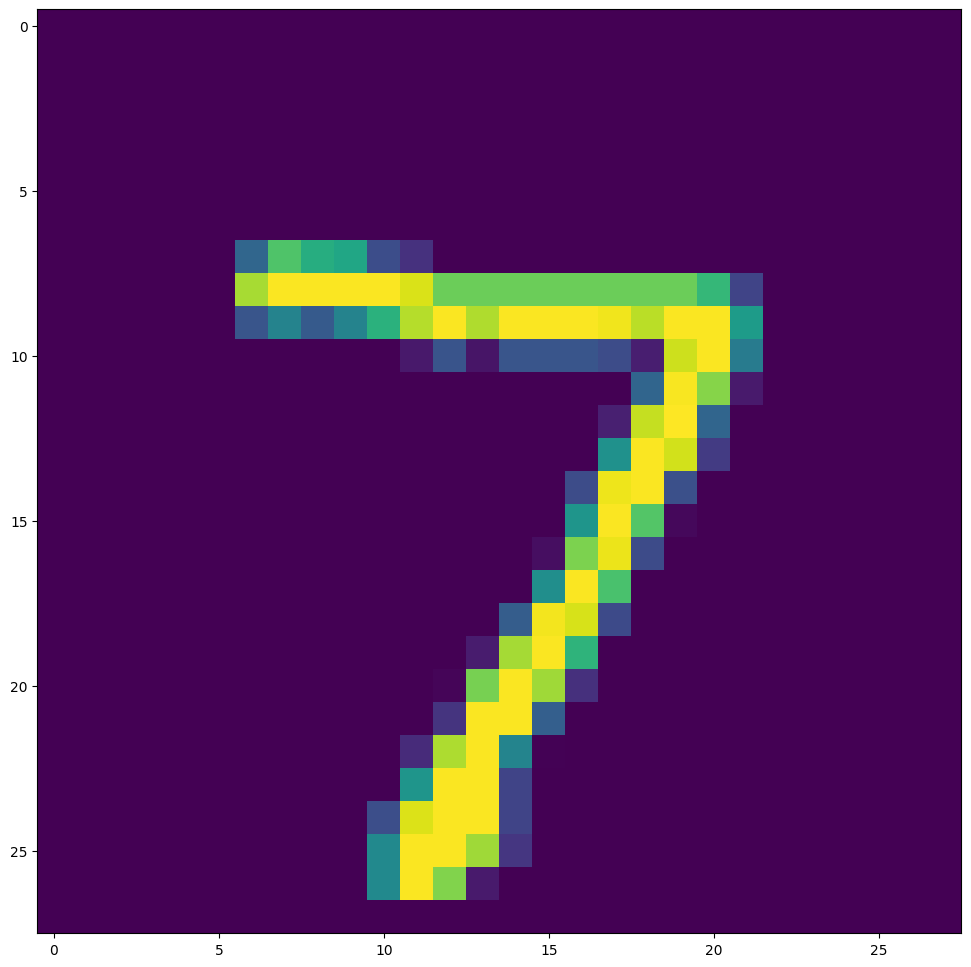

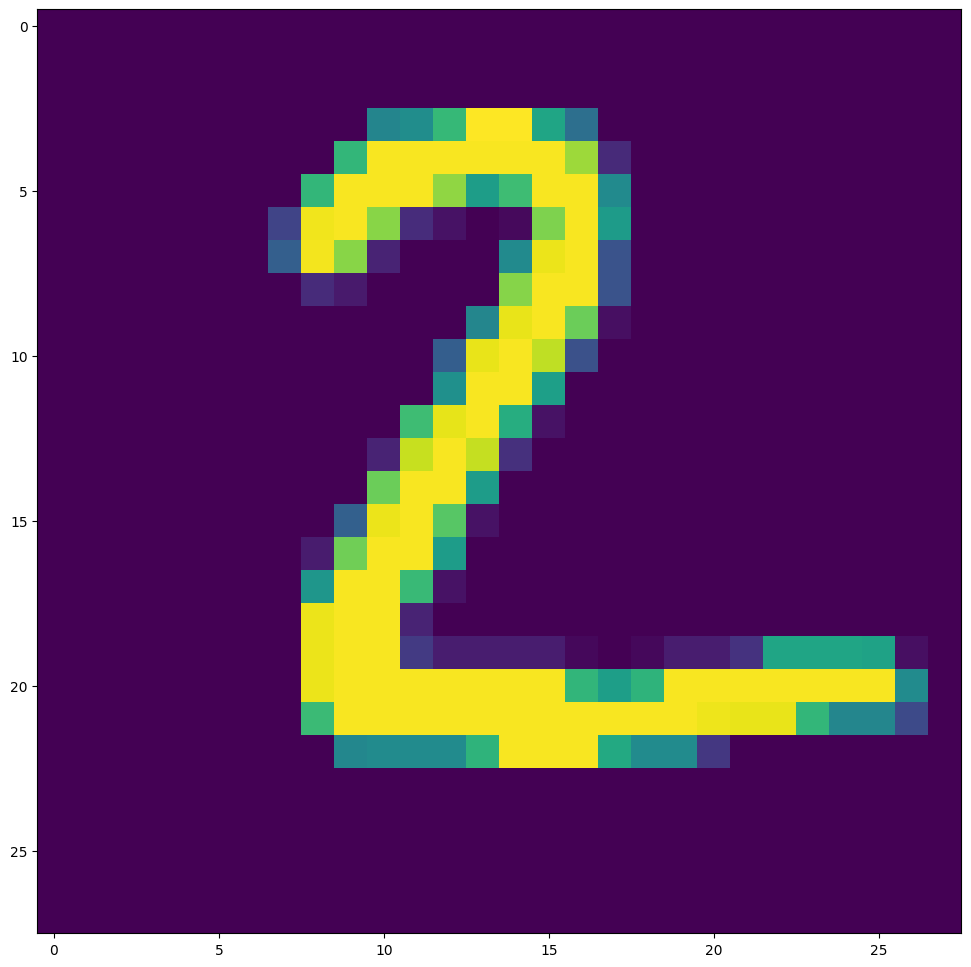

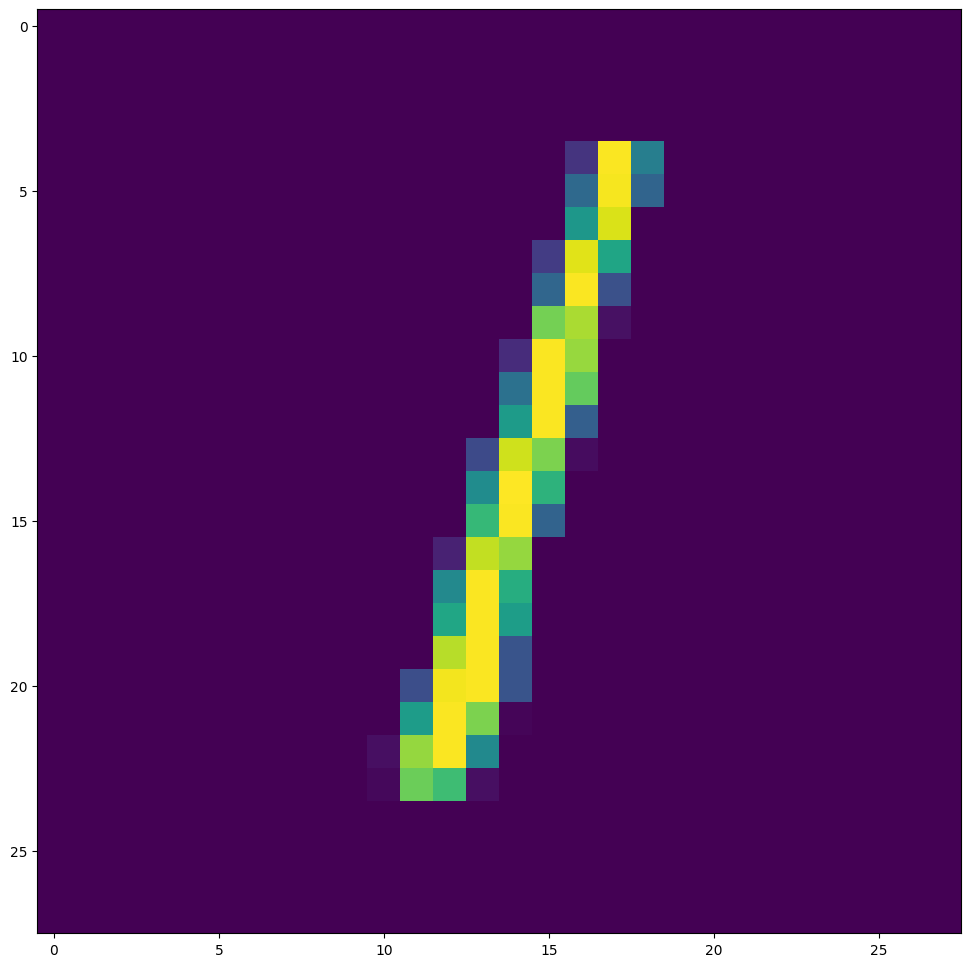

In [203]:
import matplotlib.pyplot as plt
for x in test_ds.select(range(3)):
    ip, label = x['input'], x['label']
    logits = model(ip)
    pred = torch.argmax(logits)
    label = torch.argmax(label)
    img = ip.reshape(28, 28) * 255
    print(pred, label)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)